In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
import foolbox as fb
from foolbox.criteria import Misclassification
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from dino_experiments.util import get_embeddings, get_seeded_data_loader, Logger, AVAILABLE_DATASETS
from skorch import NeuralNetClassifier

from my_utils import _fit, _evaluate_model

from time import time

GLOBAL_SEED = 1
RESIZE = True
BATCH_SIZE = 8
TEST_SAMPLE_SIZE = VAL_SAMPLE_SIZE = TRAIN_SAMPLE_SIZE = -1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
dataset = 'fayoum'



In [ ]:
def evaluate_advs(transformer,advs, clf):
    normalize_values = ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
    normalized_advs = TF.normalize(advs, mean =normalize_values[0], std=normalize_values[1])
    test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=len(normalized_advs), normalize=False)
    benign_labels = next(iter(test_loader))[1]
    adv_test_dataset = torch.utils.data.TensorDataset(normalized_advs, benign_labels)
    adv_test_dataloader = torch.utils.data.DataLoader(adv_test_dataset, batch_size=10)
    adv_embeddings, ys = get_embeddings(transformer, adv_test_dataloader,TEST_SAMPLE_SIZE)
    acc = clf.score(adv_embeddings, ys)
    return acc

def get_torch_classifier():
    #m = torch.load('/home/florian/dev/DINO-ViT_fruit_quality_assessment/saved-models/torch-classifier.pkl')
    try:
        m = torch.load('/home/florian/dev/DINO-ViT_fruit_quality_assessment/saved-models/torch-classifier.pkl')
    except:
        print('no model to load found')
        train_loader = get_seeded_data_loader(dataset, "train", GLOBAL_SEED, resize=RESIZE, batch_size=BATCH_SIZE)
        val_loader = get_seeded_data_loader(dataset, "val", GLOBAL_SEED, resize=RESIZE, batch_size=BATCH_SIZE)
        transformer = torch.hub.load('facebookresearch/dino:main', 'dino_vits8', verbose=False).to(device)
        m = DinoClassifier(transformer, 384, 4).cuda()
        for param in m.feature_extractor.parameters():
            param.requires_grad = False
        _fit(m, train_loader, val_loader, 25, device)
    test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=BATCH_SIZE)
    criterion = nn.CrossEntropyLoss()
    torch.save(m, '/home/florian/dev/DINO-ViT_fruit_quality_assessment/saved-models/torch-classifier.pkl')
    accuracy, loss = _evaluate_model(m, test_loader, device, criterion)
    print('test acc:', accuracy,', test loss:' ,loss)
    return m,accuracy

def get_skorch_classifier_acc():
    test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=60)
    train_loader = get_seeded_data_loader(dataset, "train", GLOBAL_SEED, resize=RESIZE, batch_size=176)
    val_loader = get_seeded_data_loader(dataset, "val", GLOBAL_SEED, resize=RESIZE, batch_size=60)
    X_train_only,y_train_only = next(iter(train_loader))
    X_val,y_val = next(iter(val_loader))
    X_train, y_train = np.concatenate((X_train_only, X_val)), np.concatenate((y_train_only, y_val))
    
    transformer = torch.hub.load('facebookresearch/dino:main', 'dino_vits8', verbose=False).to(device)
    m = DinoClassifier(transformer, 384, 4)
    for param in m.feature_extractor.parameters():
        param.requires_grad = False
    net = NeuralNetClassifier(
        m,
        max_epochs=30,
        criterion=nn.CrossEntropyLoss(),
        optimizer=optim.Adam,
        batch_size=8,
    )
    
    net.fit(X_train, y_train)
    test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=7*8)
    X_test, y_test = next(iter(test_loader))
    acc = net.score(X_test, y_test)
    print(acc)
    return acc

def get_original_classifier():
    transformer = torch.hub.load('facebookresearch/dino:main', 'dino_vits8', verbose=False)
    transformer.to(device)
    
    test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=BATCH_SIZE)
    X_test, y_test = get_embeddings(transformer, test_loader, TEST_SAMPLE_SIZE, batch_size=BATCH_SIZE)
    
    train_loader = get_seeded_data_loader(dataset, "train", GLOBAL_SEED, batch_size=BATCH_SIZE, resize=RESIZE)
    X_train, y_train = get_embeddings(transformer, train_loader, TRAIN_SAMPLE_SIZE, batch_size=BATCH_SIZE)
    
    clf = MLPClassifier(random_state=GLOBAL_SEED, max_iter=10000)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    
    return clf, acc


def get_adversarial_robustness(m, attack,eps, confidence=.02):
    test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=4, normalize=False)
    
    m.eval()
    preprocessing = dict(mean=(0.6237, 0.6076, 0.5367), std=(0.1759, 0.1925, 0.3011), axis=-3)
    bounds = (0, 1)
    fmodel = fb.PyTorchModel(m, bounds=bounds,preprocessing=preprocessing)
    successful_advs = 0
    total_advs = 0
    advs = np.empty((0,3,224,224))
    if attack == 'PGD': att = fb.attacks.PGD()
    if attack == 'FGSM': att = fb.attacks.FGSM()
    if attack == 'CW': att = fb.attacks.L2CarliniWagnerAttack(confidence=confidence, binary_search_steps=5, steps=100, initial_const=1)
    if attack == 'DF': att = fb.attacks.L2DeepFoolAttack(overshoot=confidence)
    if attack == 'BB0': att = fb.attacks.L0BrendelBethgeAttack(init_attack=fb.attacks.LinearSearchBlendedUniformNoiseAttack(),binary_search_steps=10, steps=2)
    for x_batch, y_batch in test_loader:
    #x_batch, y_batch = next(iter(test_loader))
        t0=time()
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        raw, clipped, is_adv = att(
                fmodel,
                x_batch,
                criterion=fb.criteria.Misclassification(y_batch),
                epsilons=eps
            )
        #advs = np.concatenate((advs, clipped.cpu()))
        total_advs += len(is_adv)
        successful_advs += is_adv.sum()
        print('ASR:',(successful_advs/total_advs).item())
        print('time per batch:',time()-t0)
    return 1-successful_advs/total_advs, clipped.cpu().numpy()
    


class DinoClassifier(nn.Module):
    def __init__(self, feature_extractor, num_features,num_classes):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier = nn.Linear(num_features, num_classes)
        self.train_stats=np.array([])
    def forward(self, inputs):
        x = F.relu(self.feature_extractor(inputs))
        return self.classifier(x)

def pipeline():
    
    m,_ = get_torch_classifier()
    clf,_ = get_original_classifier()
    transformer = torch.hub.load('facebookresearch/dino:main', 'dino_vits8', verbose=False).to(device)
    for attack in ['FGSM', 'PGD', 'CW', 'DF', 'BB0']:
        if attack in ['FGSM', 'PGD']:epsilons=[0,.125,.25,.5,1,2,4,8]
        if attack == 'BB0': epsilons = [0,50,100,200,500,1000]
        if attack in ['CW', 'DF']: epsilons = [0,1,2,5,10,20,50,100]
        for eps in epsilons:
            if attack == 'CW': confidences = [.0,.1,.2,.4,.6]
            if attack == 'DF': confidences = [.02,.04,.08,.2,.4]
            if attack == 'BB0': confidences = [1.1, 1.3,1.5,2]
            if attack == 'PGD' or attack == 'FGSM': confidences = [None]
            for confidence in confidences:
                df = pd.DataFrame(
                    data=[[None, None]],
                    index=[f'{attack}-{eps}-{confidence}'],
                    columns=["rob","transfer-rob"],
                    dtype=float,
                )
                robustness, advs = get_adversarial_robustness(m, attack , eps, confidence)
                advs = torch.from_numpy(advs).float()
                torch.save(advs, f'./adversarial-examples/{attack}-{eps}-{confidence}.pkl')
                transfer_robustness = evaluate_advs(transformer, advs, clf)
                df['rob'] = robustness.item()
                df['transfer-rob'] = transfer_robustness
                print(df)
                df.to_csv(f'./evaluation/{attack}-{eps}-{confidence}.csv')
pipeline()

In [74]:
test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=4, normalize=False)
x, y = next(iter(test_loader))

Splitting train and test data.
Splitting train and val data.


In [75]:
np.count_nonzero((output[1][0].cpu().numpy()-x.numpy()))

616

In [76]:
import matplotlib.pyplot as plt

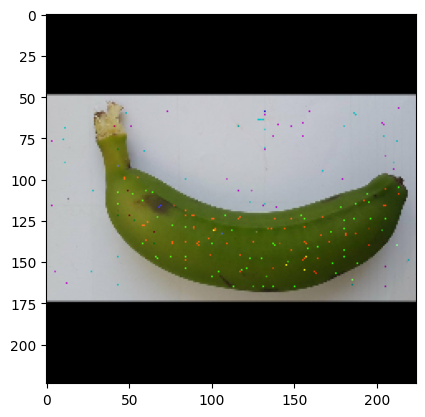

In [77]:
img1 = np.transpose(x[0], (1, 2, 0))
img2 = np.transpose(output[1][0].cpu().numpy()[0], (1, 2, 0))
plt.imshow(img2)

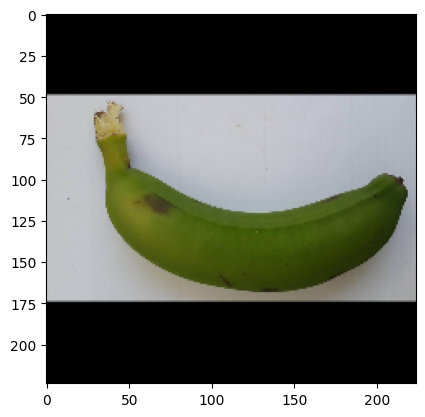

In [78]:
plt.imshow(img1)

In [3]:
def pipeline():
    
    _, m = get_torch_classifier_acc()
    _, clf = get_original_classifier_acc()
    
    for attack in ['FGSM', 'PGD', 'CW', 'DF', 'BB0']:
        if attack in ['FGSM', 'PGD']:epsilons=[.125,.25,.5,1,2,4,8]/255
        if attack == 'BB0': epsilons = [50,100,200,500,1000]
        if attack in ['CW', 'DF']: epsilons = [1,2,5,10,20,50,100]
        for eps in epsilons:
            if attack == 'CW': confidences = [.0,.1,.2,.4,.6]
            if attack == 'DF': confidences = [.02,.04,.08,.2,.4]
            if attack == 'BB0': confidences = [1.1, 1.3,1.5,2]
            if attack == 'PGD' or attack == 'FGSM': confidences = [None]
            for confidence in confidences:
                df = pd.DataFrame(
                    data=[[None, None]],
                    index=[f'{attack}-{eps}-{confidence}'],
                    columns=["rob","transfer-rob"],
                    dtype=float,
                )
                robustness, advs = get_adversarial_robustness(m, attack , eps, confidence)
                advs = torch.from_numpy(advs).float()
                #torch.save(advs, f'./adversarial-examples/{attack}-{eps}-{confidence}.pkl')
                transfer_robustness = evaluate_advs(advs)
                df['rob'] = robustness.item()
                df['transfer-rob'] = transfer_robustness
                print(df)
                #df.to_csv(f'./evaluation/{attack}-{eps}-{confidence}.csv')
            

In [10]:
pipeline()

normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.
test acc: 96.29629629629629 , test loss: 0.13909855538180896
normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.
normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.


KeyboardInterrupt: 

In [4]:

import torch.nn.functional as F

class DinoClassifier(nn.Module):
    def __init__(self, feature_extractor, num_features,num_classes):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier = nn.Linear(num_features, num_classes)
        self.train_stats=np.array([])
    def forward(self, inputs):
        x = F.relu(self.feature_extractor(inputs))
        return self.classifier(x)

In [5]:
def evaluate_advs(advs):
    normalize_values = ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
    normalized_advs = TF.normalize(advs, mean =normalize_values[0], std=normalize_values[1])
    test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=len(normalized_advs), normalize=False)
    benign_labels = next(iter(test_loader))[1]
    adv_test_dataset = torch.utils.data.TensorDataset(normalized_advs, benign_labels)
    adv_test_dataloader = torch.utils.data.DataLoader(adv_test_dataset, batch_size=10)
    adv_embeddings, ys = get_embeddings(transformer, adv_test_dataloader,TEST_SAMPLE_SIZE)
    acc = clf.score(adv_embeddings, ys)
    return acc

def get_torch_classifier_acc():
    transformer = torch.hub.load('facebookresearch/dino:main', 'dino_vits8', verbose=False).to(device)
    m = torch.load('./saved-models/torch-classifier.pkl')
    try:
        m = torch.load('./saved-models/torch-classifier.pkl')
    except:
        
        train_loader = get_seeded_data_loader(dataset, "train", GLOBAL_SEED, resize=RESIZE, batch_size=BATCH_SIZE)
        val_loader = get_seeded_data_loader(dataset, "val", GLOBAL_SEED, resize=RESIZE, batch_size=BATCH_SIZE)
        transformer = torch.hub.load('facebookresearch/dino:main', 'dino_vits8', verbose=False).to(device)
        m = DinoClassifier(transformer, 384, 4).cuda()
        for param in m.feature_extractor.parameters():
            param.requires_grad = False
        _fit(m, train_loader, val_loader, 25, device)
    test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=BATCH_SIZE)
    criterion = nn.CrossEntropyLoss()
    torch.save(m, './saved-models/torch-classifier.pkl')
    accuracy, loss = _evaluate_model(m, test_loader, device, criterion)
    print('test acc:', accuracy,', test loss:' ,loss)
    return accuracy, m

def get_skorch_classifier_acc():
    test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=60)
    train_loader = get_seeded_data_loader(dataset, "train", GLOBAL_SEED, resize=RESIZE, batch_size=176)
    val_loader = get_seeded_data_loader(dataset, "val", GLOBAL_SEED, resize=RESIZE, batch_size=60)
    X_train_only,y_train_only = next(iter(train_loader))
    X_val,y_val = next(iter(val_loader))
    X_train, y_train = np.concatenate((X_train_only, X_val)), np.concatenate((y_train_only, y_val))
    
    transformer = torch.hub.load('facebookresearch/dino:main', 'dino_vits8', verbose=False).to(device)
    m = DinoClassifier(transformer, 384, 4)
    for param in m.feature_extractor.parameters():
        param.requires_grad = False
    net = NeuralNetClassifier(
        m,
        max_epochs=30,
        criterion=nn.CrossEntropyLoss(),
        optimizer=optim.Adam,
        batch_size=8,
    )
    
    net.fit(X_train, y_train)
    test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=7*8)
    X_test, y_test = next(iter(test_loader))
    acc = net.score(X_test, y_test)
    print(acc)
    return acc

def get_original_classifier_acc():
    transformer = torch.hub.load('facebookresearch/dino:main', 'dino_vits8', verbose=False)
    transformer.to(device)
    
    test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=BATCH_SIZE)
    X_test, y_test = get_embeddings(transformer, test_loader, TEST_SAMPLE_SIZE, batch_size=BATCH_SIZE)
    
    train_loader = get_seeded_data_loader(dataset, "train", GLOBAL_SEED, batch_size=BATCH_SIZE, resize=RESIZE)
    X_train, y_train = get_embeddings(transformer, train_loader, TRAIN_SAMPLE_SIZE, batch_size=BATCH_SIZE)
    
    clf = MLPClassifier(random_state=GLOBAL_SEED, max_iter=10000)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    
    return acc,clf

import foolbox as fb
from foolbox.criteria import Misclassification

def get_adversarial_robustness(m, attack,eps, confidence=.02):
    test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=4, normalize=False)
    
    m.eval()
    preprocessing = dict(mean=(0.6237, 0.6076, 0.5367), std=(0.1759, 0.1925, 0.3011), axis=-3)
    bounds = (0, 1)
    fmodel = fb.PyTorchModel(m, bounds=bounds,preprocessing=preprocessing)
    successful_advs = 0
    total_advs = 0
    advs = np.empty((0,3,224,224))
    if attack == 'PGD': att = fb.attacks.PGD()
    if attack == 'FGSM': att = fb.attacks.FGSM()
    if attack == 'CW': att = fb.attacks.L2CarliniWagnerAttack(confidence=confidence, binary_search_steps=3, steps=100, initial_const=1)
    if attack == 'DF': att = fb.attacks.L2DeepFoolAttack(overshoot=confidence)
    if attack == 'BB0': att = fb.attacks.L0BrendelBethgeAttack(init_attack=fb.attacks.LinearSearchBlendedUniformNoiseAttack(),overshoot=confidence, binary_search_steps=3, lr_num_decay=5, steps=50, lr=.01)
    for x_batch, y_batch in test_loader:
        t0=time()
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        raw, clipped, is_adv = att(fmodel, x_batch, y_batch, epsilons=eps)
        advs = np.concatenate((advs, clipped.cpu()))
        total_advs += len(is_adv)
        successful_advs += is_adv.sum()
        print('ASR:',(successful_advs/total_advs).item())
        print('time per batch:',time()-t0)
    return 1-successful_advs/total_advs, advs
        

In [55]:
output = get_adversarial_robustness('BB0',eps=200, confidence = 1.3)
bb0_advs = torch.from_numpy(output[1]).float()
#torch.save(bb0_advs, 'bb0_advs-confidence-1.1.pkl')

Splitting train and test data.
Splitting train and val data.
careful, reducing L0 norms not yet supported, therefore the unclipped adversarial examples and successes are returned
tensor(1., device='cuda:0')


In [6]:
acc, m = get_torch_classifier_acc()
acc

normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.
test acc: 96.29629629629629 , test loss: 0.13909855538180896


96.29629629629629

In [7]:
get_skorch_classifier_acc()

normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.
normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.
normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        3.6833       0.7500        2.7314  28.4676
      2        2.7222       0.7045        3.5502  28.9190
normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.


KeyboardInterrupt: 

In [6]:
acc, clf = get_original_classifier_acc()
acc

normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.
normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.


0.9259259259259259

In [23]:
output = get_adversarial_robustness('PGD',eps=8/255)

Splitting train and test data.
Splitting train and val data.
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')


In [31]:

pgd_advs = torch.from_numpy(output[1]).float()
torch.save(pgd_advs, 'pgd_advs.pkl')

In [52]:
output = get_adversarial_robustness('DF', confidence=.1,eps=1)
df_advs = torch.from_numpy(output[1]).float()
torch.save(pgd_advs, 'df_advs-overshoot-.1.pkl')

Splitting train and test data.
Splitting train and val data.
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')


In [22]:
for confidence in [0,.1,.2,.3,.4,.5,.6,.7]:
    t0 = time.time()
    output = get_adversarial_robustness(m,'CW',eps=1, confidence = confidence)
    cw_advs = torch.from_numpy(output[1]).float()
    torch.save(cw_advs, 'cw_advs-confidence-{confidence}.pkl')
    print(time.time()-t0)
    transformer = torch.hub.load('facebookresearch/dino:main', 'dino_vits8', verbose=False).to(device)
    print(f'ASR: 1-{output[0]} transfer-ASR:1-{evaluate_advs(cw_advs)}')

Splitting train and test data.
Splitting train and val data.
418.2131767272949
Splitting train and test data.
Splitting train and val data.
ASR: 0.0 transfer-ASR:0.6851851851851852
Splitting train and test data.
Splitting train and val data.
421.675372838974
Splitting train and test data.
Splitting train and val data.
ASR: 0.0 transfer-ASR:0.6481481481481481
Splitting train and test data.
Splitting train and val data.
419.2333416938782
Splitting train and test data.
Splitting train and val data.
ASR: 0.0 transfer-ASR:0.6111111111111112
Splitting train and test data.
Splitting train and val data.
411.7548382282257
Splitting train and test data.
Splitting train and val data.
ASR: 0.0 transfer-ASR:0.5925925925925926
Splitting train and test data.
Splitting train and val data.
409.1054780483246
Splitting train and test data.
Splitting train and val data.
ASR: 0.0 transfer-ASR:0.5740740740740741
Splitting train and test data.
Splitting train and val data.
406.5728840827942
Splitting train a

In [28]:
for confidence in [1.1,1.3,1.5]:
    t0 = time.time()
    output = get_adversarial_robustness(m,'BB0',eps=100, confidence = confidence)
    cw_advs = torch.from_numpy(output[1]).float()
    torch.save(cw_advs, 'cw_advs-confidence-.2.pkl')
    print(time.time()-t0)
    transformer = torch.hub.load('facebookresearch/dino:main', 'dino_vits8', verbose=False).to(device)
    print(f'ASR: 1-{output[0]} transfer-ASR:1-{evaluate_advs(cw_advs)}')

Splitting train and test data.
Splitting train and val data.
careful, reducing L0 norms not yet supported, therefore the unclipped adversarial examples and successes are returned
ASR: 1.0
time per batch: 83.92415714263916
careful, reducing L0 norms not yet supported, therefore the unclipped adversarial examples and successes are returned
ASR: 1.0
time per batch: 81.33715319633484
careful, reducing L0 norms not yet supported, therefore the unclipped adversarial examples and successes are returned
ASR: 1.0
time per batch: 85.74849605560303
careful, reducing L0 norms not yet supported, therefore the unclipped adversarial examples and successes are returned
ASR: 1.0
time per batch: 78.50417113304138
careful, reducing L0 norms not yet supported, therefore the unclipped adversarial examples and successes are returned
ASR: 1.0
time per batch: 216.78763890266418
careful, reducing L0 norms not yet supported, therefore the unclipped adversarial examples and successes are returned
ASR: 1.0
time p

In [17]:
del transformer
torch.cuda.empty_cache() # PyTorch thing


  Using cached numpy-1.26.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.0
    Uninstalling numpy-1.21.0:
      Successfully uninstalled numpy-1.21.0


In [158]:
cw_advs = torch.from_numpy(output[1]).float()
torch.save(cw_advs, 'cw_advs.pkl')

In [71]:
cw_advs = torch.load('cw_advs-confidence-.1.pkl')

In [72]:
import torchvision.transforms.functional as TF
def evaluate_advs():
    normalize_values = ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
    normalized_advs = TF.normalize(cw_advs, mean =normalize_values[0], std=normalize_values[1])
    test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=len(normalized_advs), normalize=False)
    benign_labels = next(iter(test_loader))[1]
    adv_test_dataset = torch.utils.data.TensorDataset(normalized_advs, benign_labels)
    adv_test_dataloader = torch.utils.data.DataLoader(adv_test_dataset, batch_size=10)
    adv_embeddings, ys = get_embeddings(transformer, adv_test_dataloader,TEST_SAMPLE_SIZE)
    acc = clf.score(adv_embeddings, ys)
    return acc

In [73]:
evaluate_advs()

Splitting train and test data.
Splitting train and val data.


0.7592592592592593

In [56]:
import torchvision.transforms.functional as TF
normalize_values = ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
normalized_advs = TF.normalize(bb0_advs, mean =normalize_values[0], std=normalize_values[1])


In [57]:
test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=4, normalize=False)
benign_samples = next(iter(test_loader))[0]
benign_labels = next(iter(test_loader))[1]

Splitting train and test data.
Splitting train and val data.


In [58]:
adv_test_dataset = torch.utils.data.TensorDataset(normalized_advs, benign_labels)

adv_test_dataloader = torch.utils.data.DataLoader(adv_test_dataset, batch_size=10)

In [59]:
adv_embeddings, ys = get_embeddings(transformer, adv_test_dataloader,TEST_SAMPLE_SIZE)

In [60]:
#preds = clf.predict(adv_embeddings)
acc = clf.score(adv_embeddings, ys)
acc

0.75

In [ ]:
test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=BATCH_SIZE)
train_loader = get_seeded_data_loader(dataset, "train", GLOBAL_SEED, resize=RESIZE, batch_size=BATCH_SIZE)
val_loader = get_seeded_data_loader(dataset, "val", GLOBAL_SEED, resize=RESIZE, batch_size=BATCH_SIZE)

In [50]:
transformer = torch.hub.load('facebookresearch/dino:main', 'dino_vits8', verbose=False).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
accuracy, loss = _evaluate_model(m, test_loader, device, criterion)
accuracy, loss

(96.29629629629629, 0.13909855538180896)

In [36]:
test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=60)
train_loader = get_seeded_data_loader(dataset, "train", GLOBAL_SEED, resize=RESIZE, batch_size=176)
val_loader = get_seeded_data_loader(dataset, "val", GLOBAL_SEED, resize=RESIZE, batch_size=60)

normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.
normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.
normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.


In [17]:
transformer = torch.hub.load('facebookresearch/dino:main', 'dino_vits8', verbose=False).to(device)
m = DinoClassifier(transformer, 384, 4)
for param in m.feature_extractor.parameters():
    param.requires_grad = False

In [18]:

from skorch import NeuralNetClassifier
net = NeuralNetClassifier(
    m,
    max_epochs=30,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.Adam,
    batch_size=8,
    # Shuffle training data on each epoch
    #iterator_train__shuffle=True,
)

In [19]:
X_train_only,y_train_only = next(iter(train_loader))
X_val,y_val = next(iter(val_loader))
X_train, y_train = np.concatenate((X_train_only, X_val)), np.concatenate((y_train_only, y_val))

In [20]:

net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.5818       0.7273        1.6660  27.3533
      2        1.5318       0.7955        0.6161  27.5931
      3        0.9618       0.7955        2.1884  27.5277
      4        0.9144       0.7727        2.5726  27.4869
      5        2.2796       0.7727        4.5954  27.3632
      6        2.5071       0.7955        4.5149  27.3788
      7        1.5210       0.8409        3.1583  27.4693
      8        0.9557       0.7955        2.7048  27.4665
      9        1.0204       0.8409        2.6092  27.6374
     10        0.8701       0.8636        1.4097  27.6310
     11        0.5128       0.8636        0.6001  27.4725
     12        0.2819       0.8636        0.5439  27.5361
     13        0.1919       0.8636        0.5792  27.4407
     14        0.1310       0.8636        0.5839  27.4604
     15        0.1198       0.8636        0.6073  27.4729
     16       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DinoClassifier(
    (feature_extractor): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=384, out_features=1152, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=384, out_features=384, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=384, out_features=1536, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=153

In [2]:
test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=7*8)
X_test, y_test = next(iter(test_loader))

NameError: name 'dataset' is not defined

In [22]:
test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=7*8)
X_test, y_test = next(iter(test_loader))
acc = net.score(X_test, y_test)

In [23]:
acc

0.9814814814814815

In [34]:
transformer = torch.hub.load('facebookresearch/dino:main', 'dino_vits8', verbose=False).cuda()


In [7]:
train_loader = get_seeded_data_loader(dataset, "train", GLOBAL_SEED, batch_size=BATCH_SIZE, resize=RESIZE)
X_train, y_train = get_embeddings(transformer, train_loader, TRAIN_SAMPLE_SIZE, batch_size=BATCH_SIZE)

normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.


In [8]:
clf = MLPClassifier(random_state=GLOBAL_SEED, max_iter=10000, hidden_layer_sizes=(20), activation='relu', solver='adam')

In [9]:
clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=20, max_iter=10000, random_state=1)

In [10]:
X_test, y_test = get_embeddings(transformer, test_loader, TEST_SAMPLE_SIZE, batch_size=500)

In [11]:
preds = clf.predict(X_test)

In [12]:
acc = clf.score(X_test, y_test)
acc

0.9444444444444444

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import torch
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from dino_experiments.util import get_embeddings, get_seeded_data_loader, Logger, AVAILABLE_DATASETS
GLOBAL_SEED = 42
RESIZE = True
BATCH_SIZE = 8
TEST_SAMPLE_SIZE = VAL_SAMPLE_SIZE = TRAIN_SAMPLE_SIZE = -1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = 'fayoum'

test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=BATCH_SIZE)
transformers = {'dino_vits8': torch.hub.load('facebookresearch/dino:main', 'dino_vits8', verbose=False)}
transformer = list(transformers.values())[0]
transformer.to(device)
clf = MLPClassifier(random_state=GLOBAL_SEED, max_iter=10000)

X_test, y_test = get_embeddings(transformer, test_loader, TEST_SAMPLE_SIZE, batch_size=BATCH_SIZE)

train_loader = get_seeded_data_loader(dataset, "train", GLOBAL_SEED, batch_size=BATCH_SIZE, resize=RESIZE)
X_train, y_train = get_embeddings(transformer, train_loader, TRAIN_SAMPLE_SIZE, batch_size=BATCH_SIZE)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)

acc = clf.score(X_test, y_test)
acc

prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds)

prec, rec, f1, _
print(acc)

normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.
normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.
0.9074074074074074


# Attack

In [106]:
test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=BATCH_SIZE, normalize=False)

Splitting train and test data.
Splitting train and val data.


In [112]:
import foolbox as fb
preprocessing = dict(mean=(0.6237, 0.6076, 0.5367), std=(0.1759, 0.1925, 0.3011), axis=-3)
bounds = (0, 1)
fmodel = fb.PyTorchModel(m, bounds=bounds,preprocessing=preprocessing)

/home/florian/anaconda3/envs/fruit-qa-3-9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  warnings.warn(


In [113]:
x_batch, y_batch = next(iter(test_loader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)
x_batch.min(), x_batch.max()

(tensor(0., device='cuda:0'), tensor(0.8994, device='cuda:0'))

In [114]:
fmodel(x_batch).argmax(axis=-1)

tensor([0, 1, 0, 0, 0, 2, 2, 1], device='cuda:0')

In [115]:
y_batch

tensor([0, 1, 0, 0, 0, 2, 2, 1], device='cuda:0')

In [116]:
fb.utils.accuracy(fmodel, x_batch, y_batch)


1.0

In [187]:
FGSM = fb.attacks.FGSM()
PGD = fb.attacks.PGD()
raw, clipped, is_adv = PGD(fmodel, x_batch, y_batch, epsilons=[0,1/255,2/255,4/255,8/255,16/255,32/255,64/255])

In [189]:
raw, clipped, is_adv =  FGSM(fmodel, x_batch, y_batch, epsilons=[0,1/255,2/255,4/255,8/255,16/255,32/255,64/255])

##### PGD

In [188]:
for i, eps in enumerate(['0/255','1/255','2/255','4/255','8/255','16/255','32/255','64/255']):
    print(eps, fb.utils.accuracy(fmodel, clipped[i], y_batch))

0/255 1.0
1/255 0.0
2/255 0.0
4/255 0.0
8/255 0.0
16/255 0.0
32/255 0.0
64/255 0.0


#### FGSM

In [190]:
for i, eps in enumerate(['0/255','1/255','2/255','4/255','8/255','16/255','32/255','64/255']):
    print(eps, fb.utils.accuracy(fmodel, clipped[i], y_batch))

0/255 1.0
1/255 0.0
2/255 0.0
4/255 0.0
8/255 0.125
16/255 0.5
32/255 0.5
64/255 0.375


In [194]:
import torchvision
mean, std = ((0.6237, 0.6076, 0.5367),(0.1759, 0.1925, 0.3011))
normalized_advs = torchvision.transforms.functional.normalize(clipped[1],mean, std)
adv_preds = m(normalized_advs).argmax(-1)

In [195]:
(y_batch == adv_preds).sum() / len(y_batch)

tensor(0., device='cuda:0')

In [167]:
(clipped-x_batch).max()

tensor(0.0078, device='cuda:0')

In [121]:
normalized_advs.min(), normalized_advs.max()

(tensor(-3.5458, device='cuda:0'), tensor(1.7460, device='cuda:0'))

In [122]:
x_batch.min(), x_batch.max()

(tensor(0., device='cuda:0'), tensor(0.8994, device='cuda:0'))

In [97]:
test_loader = get_seeded_data_loader(dataset, "test", GLOBAL_SEED, resize=RESIZE, batch_size=BATCH_SIZE, normalize=True)

normalize values ((0.6237, 0.6076, 0.5367), (0.1759, 0.1925, 0.3011))
Splitting train and test data.
Splitting train and val data.


In [98]:
x_batch, y_batch = x_batch.to(device), y_batch.to(device)
x_batch.min(), x_batch.max()

(tensor(0., device='cuda:0'), tensor(0.8994, device='cuda:0'))

In [3]:
!pip list

Package                        Version      Editable project location
------------------------------ ------------ -------------------------
adversarial-robustness-toolbox 1.16.0
anyio                          4.0.0
appdirs                        1.4.4
argon2-cffi                    23.1.0
argon2-cffi-bindings           21.2.0
arrow                          1.3.0
asttokens                      2.4.0
async-lru                      2.0.4
attrs                          23.1.0
Babel                          2.13.0
backcall                       0.2.0
beautifulsoup4                 4.12.2
bleach                         6.1.0
certifi                        2023.7.22
cffi                           1.16.0
charset-normalizer             3.3.1
click                          8.1.7
comm                           0.1.4
contourpy                      1.1.1
cycler                         0.12.1
debugpy                        1.8.0
decorator                      5.1.1
defusedxml                     0.7

In [ ]:
/home/florian/anaconda3/envs/fruit-qa-3-9/bin/python

In [13]:
X,y = next(iter(test_loader))

In [13]:
from art.estimators.classification import PyTorchClassifier


In [14]:
classifier = PyTorchClassifier(
    model=transformer,
)


TypeError: __init__() missing 3 required positional arguments: 'loss', 'input_shape', and 'nb_classes'

In [7]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from skorch import NeuralNet
from skorch.utils import to_numpy
import torch
from torch import nn
import torch.nn.functional as F
torch.manual_seed(0)

X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X, y = X.astype(np.float32), y.astype(np.int64)

class AutoencoderModule(nn.Module):
    def __init__(
            self,
            input_units=20,
            bottleneck_units=5,
    ):
        super().__init__()
        self.input_units = input_units
        self.bottleneck_units = bottleneck_units
        self.reset_params()

    def reset_params(self):
        self.dense0 = nn.Linear(self.input_units, self.bottleneck_units)
        self.dense1 = nn.Linear(self.bottleneck_units, self.input_units)

    def forward(self, X, **kwargs):
        X_bottleneck = self.dense0(X)
        X_out = self.dense1(F.relu(X_bottleneck))
        X_rec = F.tanh(X_out)  # range -1..1
        return X_rec, X_bottleneck

class NeuralNetTransformer(NeuralNet, TransformerMixin):
    def get_loss(self, y_pred, y_true, X, **kwargs):
        y_pred, _ = y_pred
        return super().get_loss(y_pred, y_true=X, X=X, **kwargs)

    def transform(self, X):
        out = []
        for outs in self.forward_iter(X, training=False):
            outs = outs[1] if isinstance(outs, tuple) else outs
            out.append(to_numpy(outs))
        transforms = np.concatenate(out, 0)
        return transforms

pipe = Pipeline([
    ('scale', MinMaxScaler(feature_range=(-1, 1))),  # range -1..1
    ('net', NeuralNetTransformer(
        AutoencoderModule,
        criterion=nn.MSELoss,
        module__bottleneck_units=5,
        lr=0.5,
    )),
    ('clf', LogisticRegression()),
])

cross_val_score(pipe, X, y, scoring='accuracy')
# returns array([ 0.61 ,  0.555,  0.72 ,  0.485,  0.56 ])

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1549        0.1397  0.0091
      2        0.1305        0.1232  0.0190
      3        0.1161        0.1135  0.0111
      4        0.1074        0.1078  0.0095
      5        0.1021        0.1044  0.0078
      6        0.0989        0.1024  0.0074
      7        0.0969        0.1011  0.0076
      8        0.0955        0.1002  0.0074
      9        0.0946        0.0996  0.0075
     10        0.0939        0.0991  0.0088
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1555        0.1388  0.0087
      2        0.1318        0.1207  0.0140
      3        0.1171        0.1096  0.0144
      4        0.1081        0.1029  0.0092
      5        0.1026        0.0989  0.0074
      6        0.0993        0.0965  0.0074
      7        0.0972        0.0949  0.0074
      8        0.0959        0.0939  0.0075
      9        0.0949        0.0

array([0.61 , 0.555, 0.72 , 0.485, 0.56 ])

In [11]:
from art.estimators.classification import SklearnClassifier
art_model = SklearnClassifier(pipe)

In [15]:
from art.attacks.evasion import FastGradientMethod

In [18]:
FastGradientMethod(estimator=art_model)

EstimatorError: FastGradientMethod requires an estimator derived from <class 'art.estimators.estimator.BaseEstimator'> and <class 'art.estimators.estimator.LossGradientsMixin'>, the provided classifier is an instance of <class 'art.estimators.classification.scikitlearn.ScikitlearnClassifier'> and is derived from (<class 'art.estimators.classification.classifier.ClassifierMixin'>, <class 'art.estimators.scikitlearn.ScikitlearnEstimator'>).

In [19]:
!pip install foolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.2 MB/s eta 0:00:00a 0:00:01m


In [21]:
transformer()

ValueError: not enough values to unpack (expected 4, got 2)

In [4]:
from baseline_experiments.model import initialize_model, unfreeze_all_params

In [10]:
m, _ = initialize_model('resnet50', 4, train_conv=False, use_pretrained=True)

In [13]:
m = torch.nn.DataParallel(m, [0])

In [14]:
m.load_state_dict(torch.load('checkpoints/resnet50_n=all_all_2023_12_17_00_43/checkpoint.pt'))

<All keys matched successfully>